# Coronal3 Striatum Synaptic Compartment Analysis

In [1]:
import spatialdata as sd
import spatialdata_plot
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
import cv2
import multiprocessing
import seaborn as sns
import matplotlib.transforms as mtransforms

from functools import partial
from skimage.filters import threshold_multiotsu, gaussian
from skimage.exposure import adjust_gamma
from spatialdata.transformations.operations import get_transformation

import os
plt.style.use("default")
plt.set_cmap("inferno")

/opt/conda/lib/python3.11/site-packages/dask/array/chunk_types.py:110: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  import cupy
/opt/conda/lib/python3.11/site-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout

<Figure size 640x480 with 0 Axes>

## Define and Load Data

In [2]:
input_dir = '../01_make_sdata/outputs/'
output_dir = 'outputs'

In [3]:
zarr = os.path.join(input_dir, "coronal3_striatum.zarr")
sdata = sd.read_zarr(zarr)
sdata

SpatialData object, with associated Zarr store: /tscc/projects/ps-yeolab3/bay001/codebase/Yeo_synapse_LLM/analysis/Dylan/aligned_analysis/01_make_sdata/outputs/coronal3_striatum.zarr
├── Images
│     ├── 'dapi_if': DataArray[cyx] (1, 10382, 10296)
│     ├── 'morphology_focus': DataTree[cyx] (5, 4356, 4392), (5, 2178, 2196), (5, 1089, 1098), (5, 544, 549), (5, 273, 275)
│     ├── 'post_if': DataArray[cyx] (1, 10382, 10296)
│     └── 'pre_if': DataArray[cyx] (1, 10382, 10296)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (4356, 4392), (2178, 2196), (1089, 1098), (544, 549), (273, 275)
│     └── 'nucleus_labels': DataTree[yx] (4356, 4392), (2178, 2196), (1089, 1098), (544, 549), (273, 275)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 13) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (3166, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (3090, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (3143, 1) (2D

In [4]:
def plot_image(sdata, image, figsize=(10, 10), cmap="inferno"):
    sdata.pl.render_images(image, cmap=cmap).pl.show(figsize=figsize, colorbar=False)
    plt.axis("off")
    plt.title("")
    plt.show()


def plot_points(sdata, points, figsize=(10, 10)):
    points = sdata[points].compute()
    points["x"] = points["x"] * 4.70588235
    points["y"] = points["y"] * 4.70588235

    plt.figure(figsize=figsize)
    sns.scatterplot(data=points, x="x", y="y", s=1)
    plt.axis("off")
    plt.title("")
    plt.gca().invert_yaxis()
    plt.show()

    return points

INFO     Rasterizing image for faster rendering.                                                                   


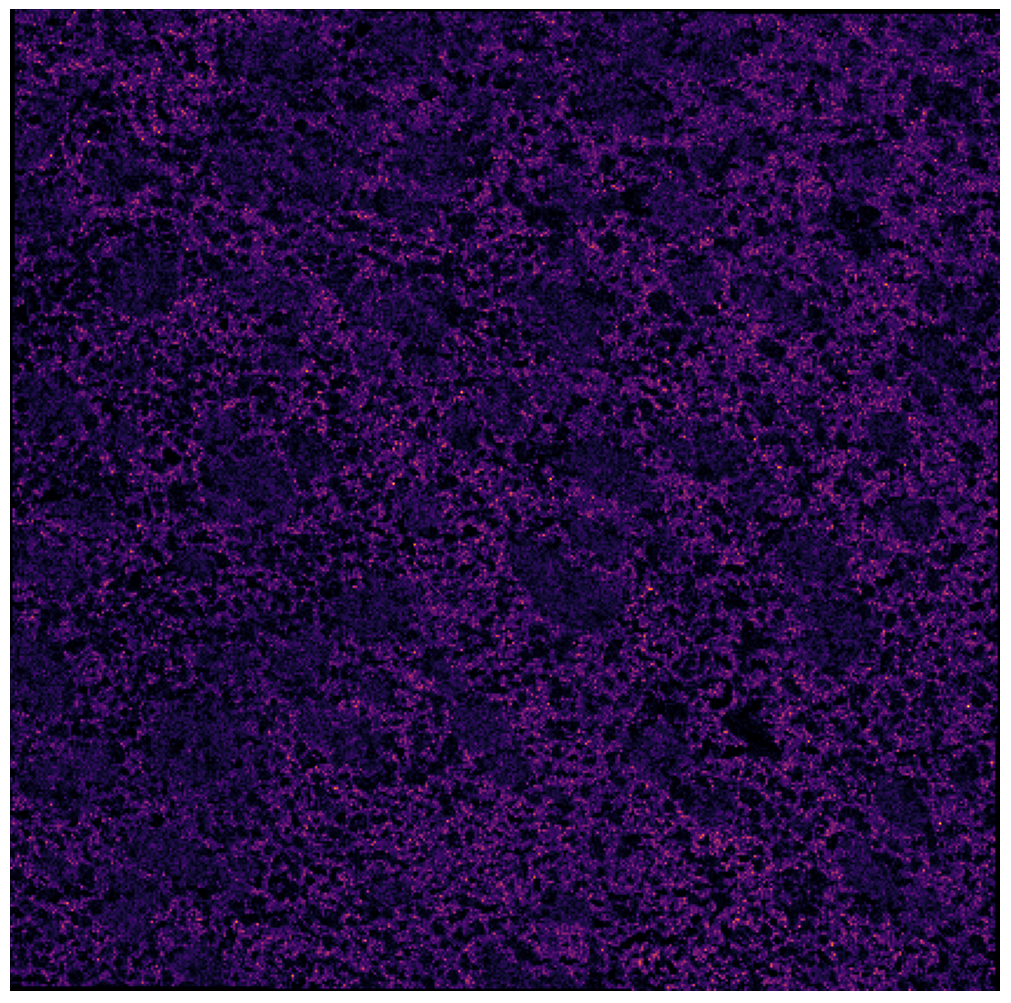

In [5]:
plot_image(sdata, "pre_if")

INFO     Rasterizing image for faster rendering.                                                                   


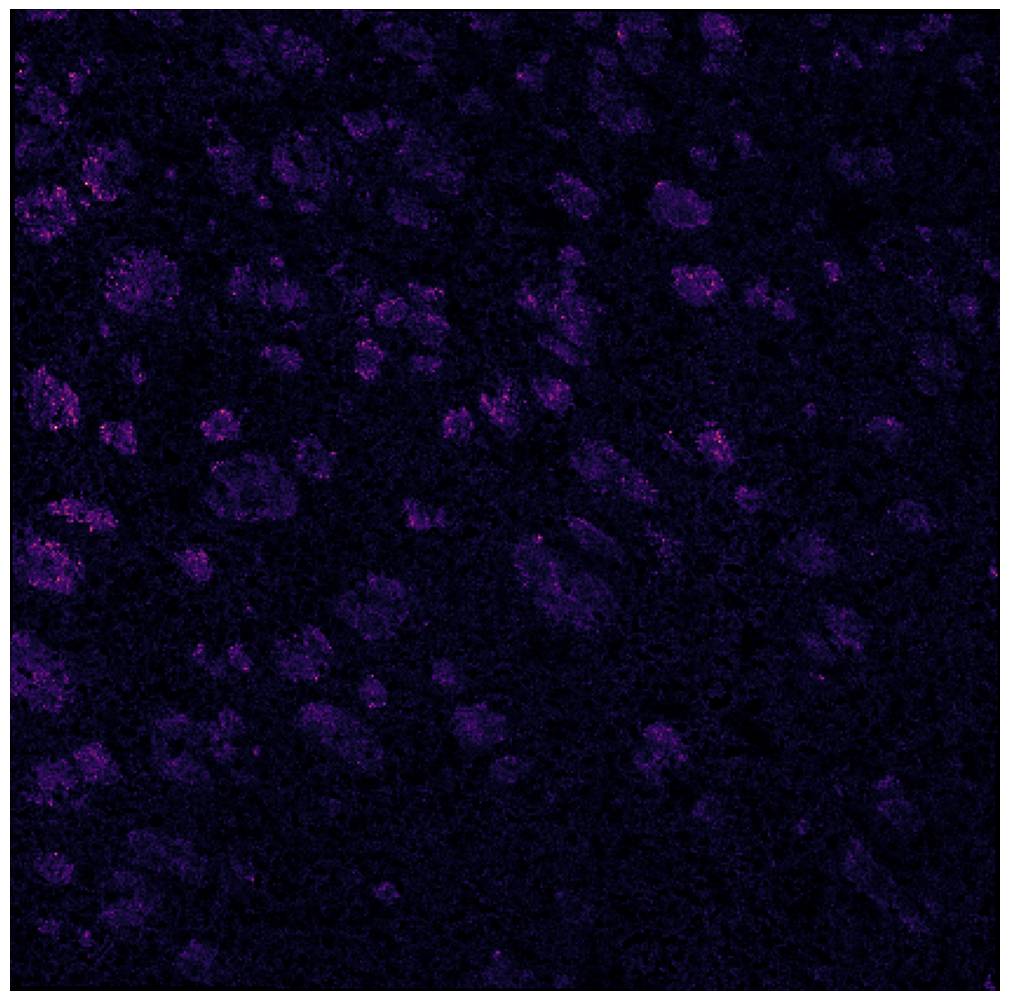

In [6]:
plot_image(sdata, "post_if")

## Segment Synapses

In [7]:
# Segment synapses
def segment_presynapse(chunk):
    img = adjust_gamma(chunk, gamma=2.4)
    img = gaussian(img, sigma=5)
    kernel = np.ones((5, 5), np.uint8)
    img = cv2.erode(img, kernel, iterations=5)
    thresholds = list(threshold_multiotsu(img, classes=3))
    regions = np.digitize(img, bins=thresholds)
    return regions


depth = 250
presynapse_input = sdata["pre_if"].sel(c=0)

presynapse_shapes = sd.map_raster(
    presynapse_input,
    segment_presynapse,
    depth=depth,
    trim=True,
    meta=np.array(()),
)
presynapse_shapes = presynapse_shapes.compute()

sdata["presynapse_multiotsu"] = sd.models.Image2DModel.parse(
    presynapse_shapes.expand_dims(dim={"c": 1})
)


# Segment synapses
def segment_postsynapse(chunk):
    img = adjust_gamma(chunk, gamma=2.1)
    img = gaussian(img, sigma=5)
    kernel = np.ones((5, 5), np.uint8)
    img = cv2.erode(img, kernel, iterations=5)
    thresholds = list(threshold_multiotsu(img, classes=3))
    regions = np.digitize(img, bins=thresholds)
    return regions


depth = 250
postsynapse_input = sdata["post_if"].sel(c=0)

postsynapse_shapes = sd.map_raster(
    postsynapse_input,
    segment_postsynapse,
    depth=depth,
    trim=True,
    meta=np.array(()),
)
postsynapse_shapes = postsynapse_shapes.compute()

sdata["postsynapse_multiotsu"] = sd.models.Image2DModel.parse(
    postsynapse_shapes.expand_dims(dim={"c": 1})
)

INFO     Rasterizing image for faster rendering.                                                                   


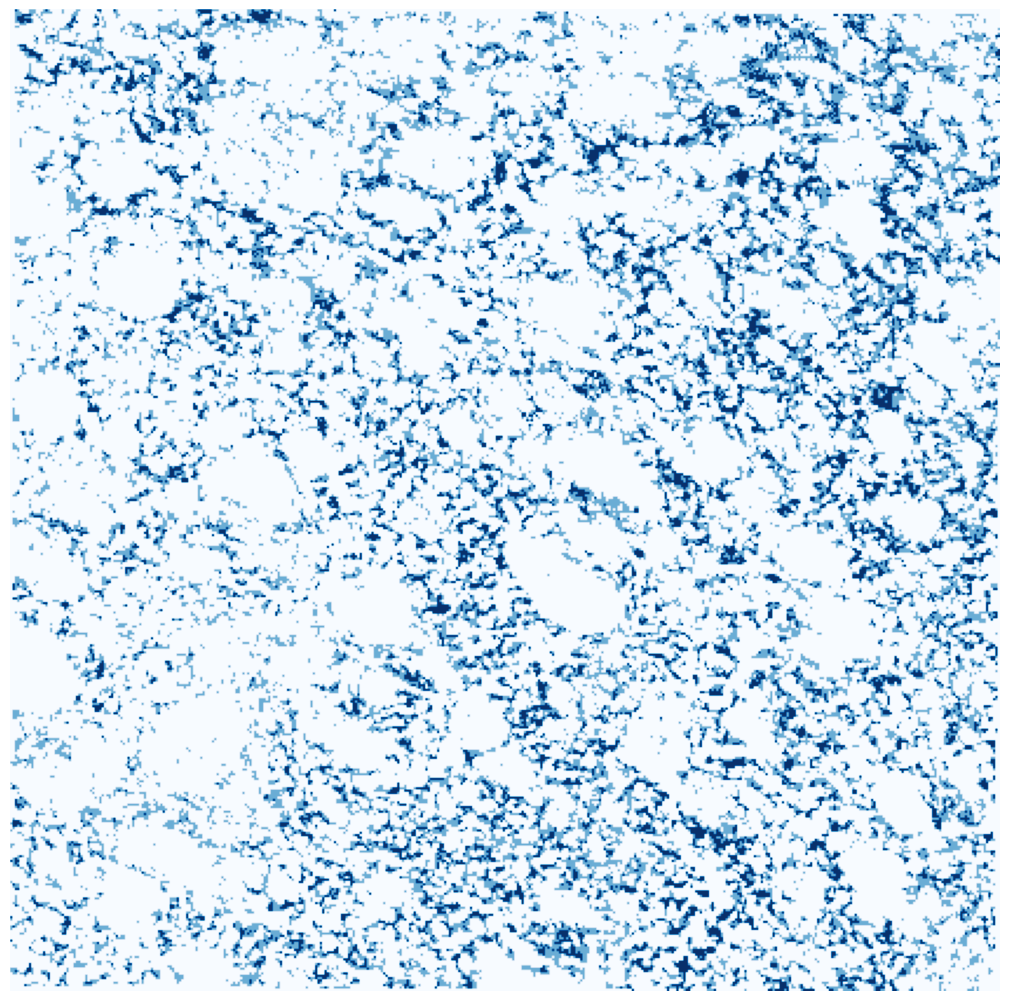

In [8]:
plot_image(sdata, "presynapse_multiotsu", cmap="Blues")

INFO     Rasterizing image for faster rendering.                                                                   


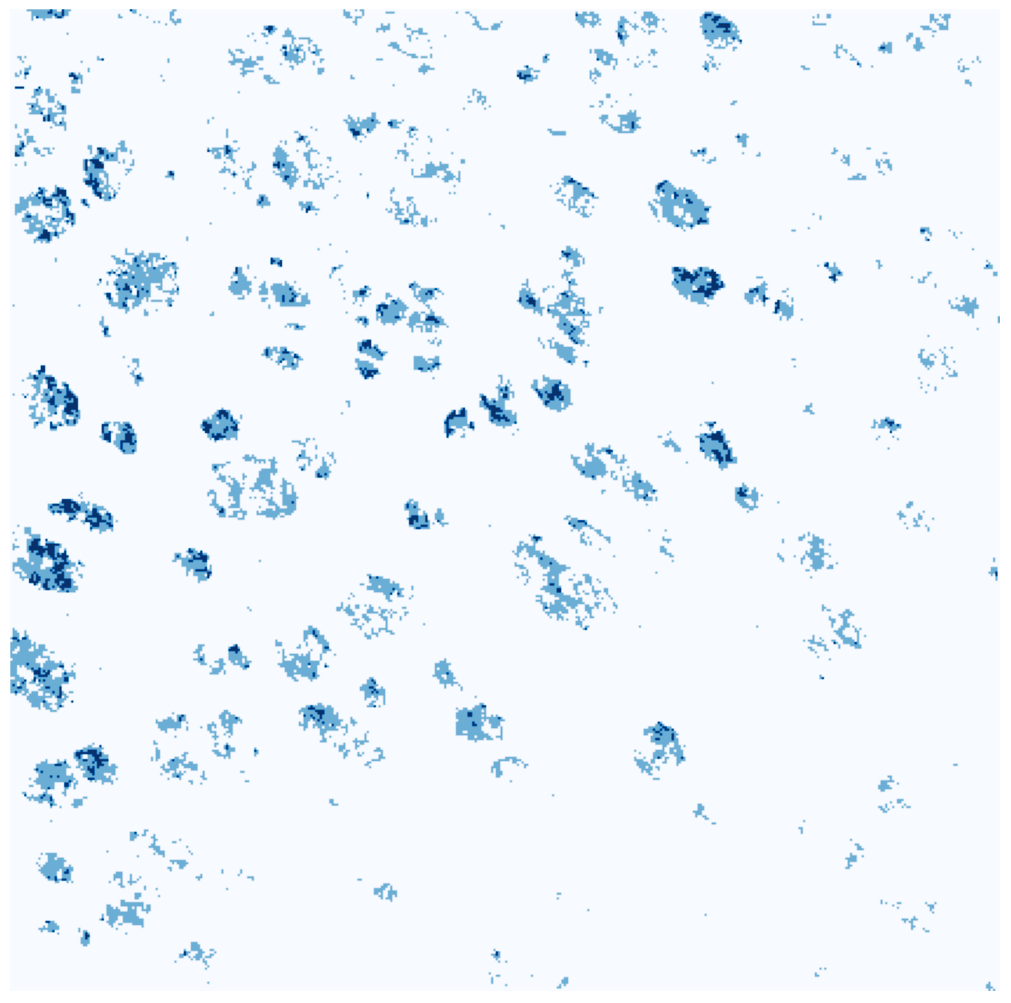

In [9]:
plot_image(sdata, "postsynapse_multiotsu", cmap="Blues")

In [10]:
synapse_trans = get_transformation(sdata["presynapse_multiotsu"], get_all=True)[
    "global"
]
transformation = {"global": synapse_trans.to_affine(("y", "x"), ("x", "y"))}

sdata["presynapse_label"] = sd.models.Labels2DModel.parse(
    (
        (sdata["presynapse_multiotsu"] == 2) | (sdata["presynapse_multiotsu"] == 1)
    ).astype(int)[0],
    transformations=transformation,
)

sdata["postsynapse_label"] = sd.models.Labels2DModel.parse(
    (
        (sdata["postsynapse_multiotsu"] == 2) | (sdata["postsynapse_multiotsu"] == 1)
    ).astype(int)[0],
    transformations=transformation,
)

sdata["transcripts"] = sdata["transcripts"].reset_index(drop=True)

/opt/conda/lib/python3.11/site-packages/spatialdata/_core/_elements.py:106: UserWarning: Key `transcripts` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


In [11]:
def label_transformation(element, input_axes, output_axes):
    trans = get_transformation(element, get_all=True)["global"]
    affine_trans = trans.to_affine_matrix(
        input_axes=input_axes, output_axes=output_axes
    )
    trans = mtransforms.Affine2D(matrix=affine_trans).inverted()
    return trans


presynapse_element = sdata["presynapse_label"]
postsynapse_element = sdata["postsynapse_label"]
input_axes = ("y", "x")
output_axes = ("x", "y")
label_trans = label_transformation(presynapse_element, input_axes, output_axes)
presynapse_coordinates_temp = set(zip(*np.where(presynapse_element.values == 1)))
postsynapse_coordinates_temp = set(zip(*np.where(postsynapse_element.values == 1)))

In [12]:
presynapse_coordinates = presynapse_coordinates_temp.difference(
    postsynapse_coordinates_temp
)
postsynapse_coordinates = postsynapse_coordinates_temp.difference(
    presynapse_coordinates_temp
)
pre_and_post_coordinates = presynapse_coordinates_temp.intersection(
    postsynapse_coordinates_temp
)

## Map Points Excluding Transcripts in Cells

In [13]:
points_df = sdata["transcripts"].compute()
points_df["coordinate_transformed"] = (
    np.floor(
        label_trans.transform(
            np.column_stack((points_df["x"] * 4.70588235, points_df["y"] * 4.70588235))
        )
    )
    .astype(int)
    .tolist()
)

points_df = points_df.loc[points_df["cell_id"] == "UNASSIGNED"]
points_df

x            y          z feature_name     cell_id  \
1         5583.265625  2569.937500  18.421875        Nlgn3  UNASSIGNED   
3         5476.515625  3204.078125  15.875000        Ndrg2  UNASSIGNED   
4         6115.484375  3468.953125  15.843750      Ppp1r1b  UNASSIGNED   
5         6210.171875  2662.578125  17.796875       Fbxl16  UNASSIGNED   
8         5477.171875  3088.234375  15.781250        Ndrg2  UNASSIGNED   
...               ...          ...        ...          ...         ...   
12065328  5476.953125  3018.812500  16.968750        Ndrg2  UNASSIGNED   
12065329  5984.390625  2988.375000  17.937500        Gria1  UNASSIGNED   
12065330  5560.453125  3391.531250  24.203125         Ulk1  UNASSIGNED   
12065334  5476.937500  3087.625000  18.562500        Ndrg2  UNASSIGNED   
12065336  6209.281250  2624.796875  19.890625       Fbxl16  UNASSIGNED   

          overlaps_nucleus codeword_category fov_name    transcript_id  \
1                        0  predesigned_gene      V13  281651074796590   
3                        0  predesigned_gene      W13  281711203555905   
4                        0  predesigned_gene      W14  281715499658545   
5                        0  predesigned_gene      V14  281655366251585   
8                        0  predesigned_gene      W13  281711203555933   
...                    ...               ...      ...              ...   
12065328                 0  predesigned_gene      W13  281711203555846   
12065329                 0  predesigned_gene      W13  281711201281928   
12065330                 0  predesigned_gene      W13  281711200450536   
12065334                 0  predesigned_gene      W13  281711203555899   
12065336                 0  predesigned_gene      V14  281655366251453   

          codeword_index  is_gene  nucleus_distance     qv  \
1                  10782     True          2.296875  40.00   
3                   1448     True          4.546875  40.00   
4                  13983     True          6.062500  40.00   
5                  17682     True          9.859375  23.00   
8                   1448     True          7.843750  20.75   
...                  ...      ...               ...    ...   
12065328            1448     True          3.859375  23.00   
12065329            3938     True          2.515625  40.00   
12065330            7745     True          1.031250  37.25   
12065334            1448     True          8.093750  40.00   
12065336           17682     True          3.593750  23.00   

         coordinate_transformed  
1                 [8102, 10299]  
3                  [9251, 3193]  
4                   [2079, 274]  
5                  [1078, 9307]  
8                  [9252, 4489]  
...                         ...  
12065328           [9260, 5267]  
12065329           [3582, 5644]  
12065330           [8298, 1100]  
12065334           [9255, 4496]  
12065336           [1090, 9730]  

[3704977 rows x 14 columns]

In [14]:
def process_points(row, binary_coordinates):
    return tuple(row["coordinate_transformed"]) in binary_coordinates


presynapse_process = partial(
    process_points,
    binary_coordinates=presynapse_coordinates,
)

postsynapse_process = partial(
    process_points,
    binary_coordinates=postsynapse_coordinates,
)

pre_and_post_process = partial(
    process_points,
    binary_coordinates=pre_and_post_coordinates,
)

points_df["presynapse"] = points_df.apply(presynapse_process, axis=1)
points_df["postsynapse"] = points_df.apply(postsynapse_process, axis=1)
points_df["pre_and_post"] = points_df.apply(pre_and_post_process, axis=1)

In [15]:
sdata["presynapse_points"] = sd.models.PointsModel.parse(
    points_df.loc[points_df["presynapse"] == True]
)
sdata["presynapse_points"].attrs = sdata["transcripts"].attrs

sdata["postsynapse_points"] = sd.models.PointsModel.parse(
    points_df.loc[points_df["postsynapse"] == True]
)
sdata["postsynapse_points"].attrs = sdata["transcripts"].attrs

sdata["pre_and_post_points"] = sd.models.PointsModel.parse(
    points_df.loc[points_df["pre_and_post"] == True]
)
sdata["pre_and_post_points"].attrs = sdata["transcripts"].attrs

## Map Points Including Transcripts in Cells

In [16]:
points_df = sdata["transcripts"].compute()
points_df["coordinate_transformed"] = (
    np.floor(
        label_trans.transform(
            np.column_stack((points_df["x"] * 4.70588235, points_df["y"] * 4.70588235))
        )
    )
    .astype(int)
    .tolist()
)
points_df

x            y          z feature_name     cell_id  \
0         5563.218750  3280.359375  19.546875         Ulk1  kjidplhl-1   
1         5583.265625  2569.937500  18.421875        Nlgn3  UNASSIGNED   
2         6277.781250  2878.078125  23.078125        Fgfr2  kpdfoncj-1   
3         5476.515625  3204.078125  15.875000        Ndrg2  UNASSIGNED   
4         6115.484375  3468.953125  15.843750      Ppp1r1b  UNASSIGNED   
...               ...          ...        ...          ...         ...   
12065332  6114.906250  3354.640625  16.859375      Ppp1r1b  kpjhlkok-1   
12065333  5989.062500  2963.984375  20.265625        Gria1  koimdilf-1   
12065334  5476.937500  3087.625000  18.562500        Ndrg2  UNASSIGNED   
12065335  6265.921875  2772.968750  19.796875        Fgfr2  lbbhihbb-1   
12065336  6209.281250  2624.796875  19.890625       Fbxl16  UNASSIGNED   

          overlaps_nucleus codeword_category fov_name    transcript_id  \
0                        1  predesigned_gene      W13  281711200450781   
1                        0  predesigned_gene      V13  281651074796590   
2                        0  predesigned_gene      V14  281655370697399   
3                        0  predesigned_gene      W13  281711203555905   
4                        0  predesigned_gene      W14  281715499658545   
...                    ...               ...      ...              ...   
12065332                 0  predesigned_gene      W14  281715499658500   
12065333                 1  predesigned_gene      W13  281711201282203   
12065334                 0  predesigned_gene      W13  281711203555899   
12065335                 1  predesigned_gene      V14  281655370696726   
12065336                 0  predesigned_gene      V14  281655366251453   

          codeword_index  is_gene  nucleus_distance     qv  \
0                   7745     True          0.000000  35.25   
1                  10782     True          2.296875  40.00   
2                   2494     True          1.453125  40.00   
3                   1448     True          4.546875  40.00   
4                  13983     True          6.062500  40.00   
...                  ...      ...               ...    ...   
12065332           13983     True          2.890625  24.25   
12065333            3938     True          0.000000  40.00   
12065334            1448     True          8.093750  40.00   
12065335            2494     True          0.000000  35.50   
12065336           17682     True          3.593750  23.00   

         coordinate_transformed  
0                  [8275, 2345]  
1                 [8102, 10299]  
2                   [305, 6900]  
3                  [9251, 3193]  
4                   [2079, 274]  
...                         ...  
12065332           [2094, 1553]  
12065333           [3531, 5917]  
12065334           [9255, 4496]  
12065335            [446, 8076]  
12065336           [1090, 9730]  

[12065337 rows x 14 columns]

In [17]:
def process_points(row, binary_coordinates):
    return tuple(row["coordinate_transformed"]) in binary_coordinates


presynapse_process = partial(
    process_points,
    binary_coordinates=presynapse_coordinates,
)

postsynapse_process = partial(
    process_points,
    binary_coordinates=postsynapse_coordinates,
)

pre_and_post_process = partial(
    process_points,
    binary_coordinates=pre_and_post_coordinates,
)

points_df["presynapse_all"] = points_df.apply(presynapse_process, axis=1)
points_df["postsynapse_all"] = points_df.apply(postsynapse_process, axis=1)
points_df["pre_and_post_all"] = points_df.apply(pre_and_post_process, axis=1)

In [18]:
sdata["presynapse_points_all"] = sd.models.PointsModel.parse(
    points_df.loc[points_df["presynapse_all"] == True]
)
sdata["presynapse_points_all"].attrs = sdata["transcripts"].attrs

sdata["postsynapse_points_all"] = sd.models.PointsModel.parse(
    points_df.loc[points_df["postsynapse_all"] == True]
)
sdata["postsynapse_points_all"].attrs = sdata["transcripts"].attrs

sdata["pre_and_post_points_all"] = sd.models.PointsModel.parse(
    points_df.loc[points_df["pre_and_post_all"] == True]
)
sdata["pre_and_post_points_all"].attrs = sdata["transcripts"].attrs

## Plot Synaptic Points

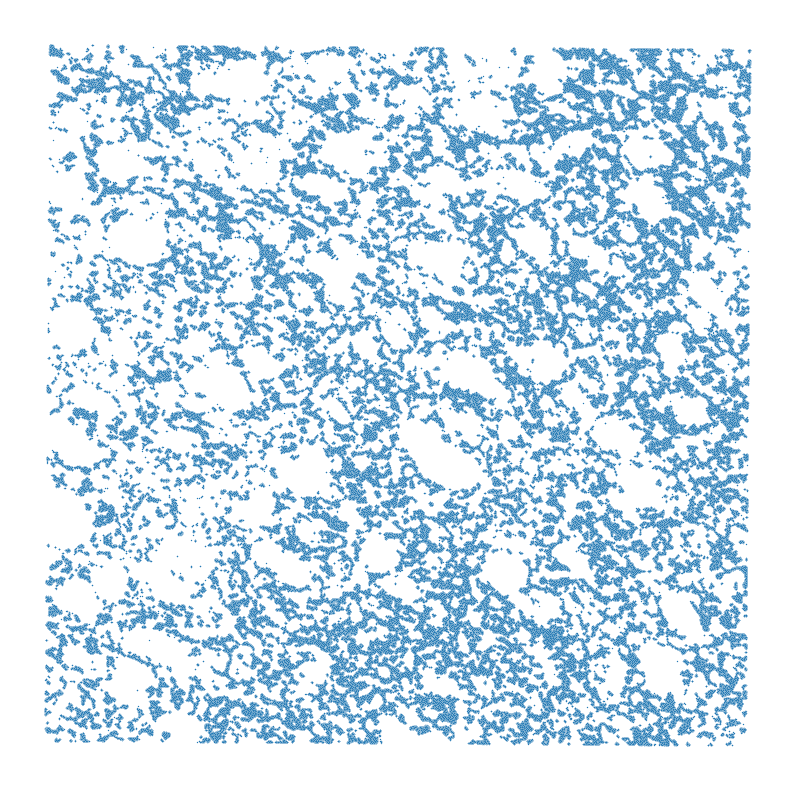

In [19]:
presynapse_points = plot_points(sdata, "presynapse_points")

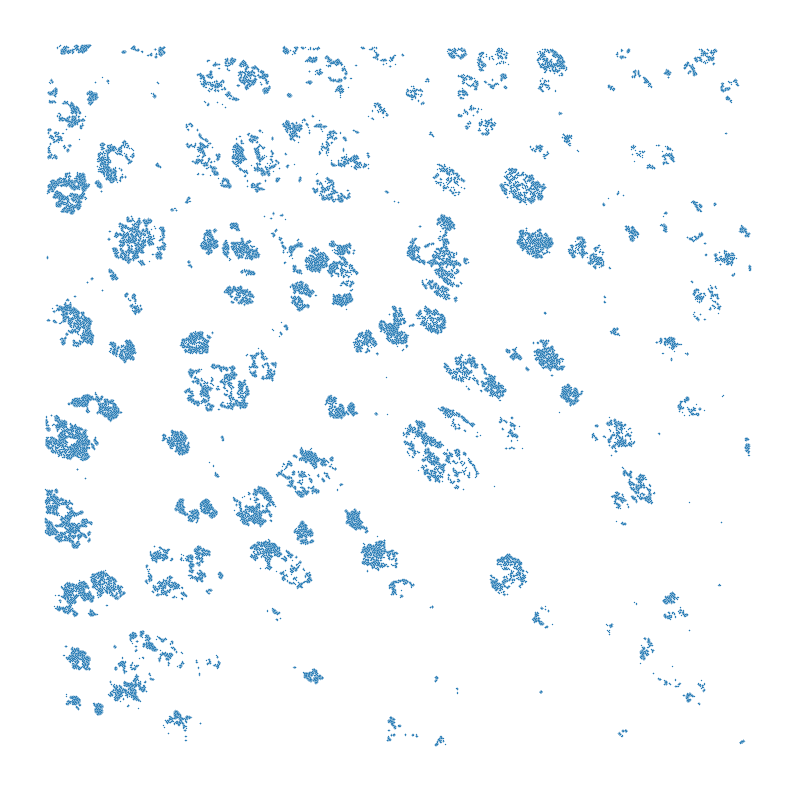

In [20]:
postsynapse_points = plot_points(sdata, "postsynapse_points")

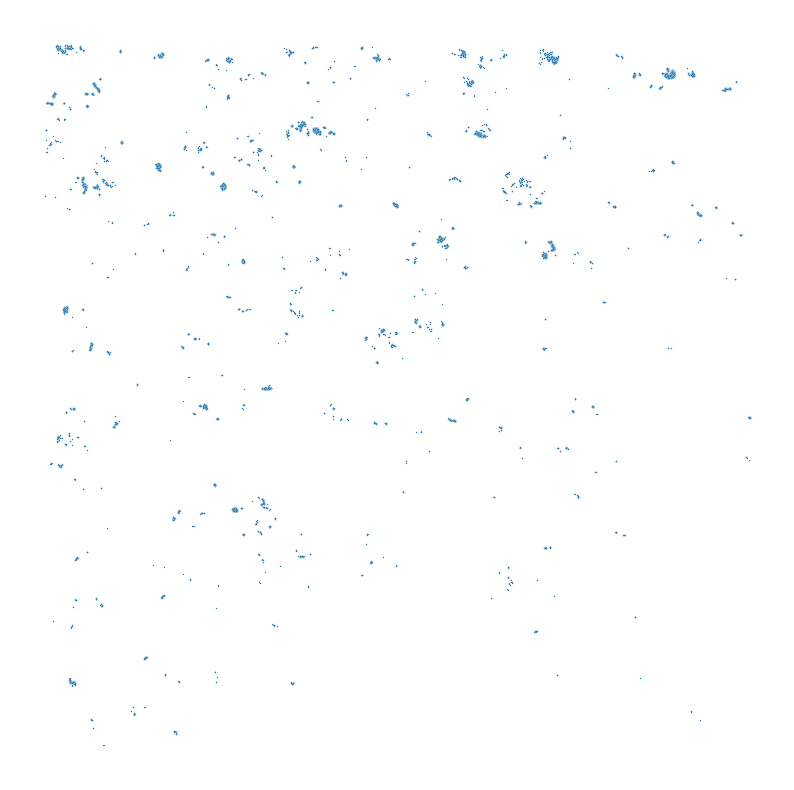

In [21]:
pre_and_post_points = plot_points(sdata, "pre_and_post_points")

## Calculate Counts

In [22]:
presynapse_compartment = presynapse_points["feature_name"].value_counts()
postsynapse_compartment = postsynapse_points["feature_name"].value_counts()
pre_and_post_compartment = pre_and_post_points["feature_name"].value_counts()

In [23]:
transcripts = sdata["transcripts"].compute()[
    ["x", "y", "feature_name", "cell_id", "overlaps_nucleus", "qv", "is_gene"]
]

transcripts["overlaps_cell"] = transcripts["cell_id"] != "UNASSIGNED"

# Group transcripts by compartment (cell/synapse) and gene, then count occurrences
gene_by_compartment = (
    transcripts.groupby(["overlaps_cell", "feature_name"]).size().unstack(fill_value=0)
).T
gene_by_compartment.columns = ["synapse", "cell"]

cell_compartment = gene_by_compartment["cell"]

# Calculate total gene count and log-transformed count
all_compartment = gene_by_compartment.sum(axis=1)

/tmp/ipykernel_2278791/2141090278.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  transcripts.groupby(["overlaps_cell", "feature_name"]).size().unstack(fill_value=0)


In [24]:
presynapse_points_all = sdata["presynapse_points_all"].compute()
postsynapse_points_all = sdata["postsynapse_points_all"].compute()
pre_and_post_points_all = sdata["pre_and_post_points_all"].compute()

presynapse_points_all = presynapse_points_all.loc[
    presynapse_points_all["cell_id"] != "UNASSIGNED"
]
postsynapse_points_all = postsynapse_points_all.loc[
    postsynapse_points_all["cell_id"] != "UNASSIGNED"
]
pre_and_post_points_all = pre_and_post_points_all.loc[
    pre_and_post_points_all["cell_id"] != "UNASSIGNED"
]

In [25]:
cell_with_presynapse_exclusion = (
    cell_compartment - presynapse_points_all["feature_name"].value_counts()
)
all_with_presynapse_exclusion = (
    all_compartment - presynapse_points_all["feature_name"].value_counts()
)

cell_with_postsynapse_exclusion = (
    cell_compartment - postsynapse_points_all["feature_name"].value_counts()
)
all_with_postsynapse_exclusion = (
    all_compartment - postsynapse_points_all["feature_name"].value_counts()
)

cell_with_presynape_and_postsynapse_exclusion = (
    cell_compartment - pre_and_post_points_all["feature_name"].value_counts()
)
all_with_presynape_and_postsynapse_exclusion = (
    all_compartment - pre_and_post_points_all["feature_name"].value_counts()
)

In [26]:
counts = pd.DataFrame(
    {
        "presynapse": presynapse_compartment,
        "postsynapse": postsynapse_compartment,
        "pre_and_post": pre_and_post_compartment,
        "cell": cell_compartment,
        "all": all_compartment,
        "cell_with_presynapse_exclusion": cell_with_presynapse_exclusion,
        "all_with_presynapse_exclusion": all_with_presynapse_exclusion,
        "cell_with_postsynapse_exclusion": cell_with_postsynapse_exclusion,
        "all_with_postsynapse_exclusion": all_with_postsynapse_exclusion,
        "cell_with_presynape_and_postsynapse_exclusion": cell_with_presynape_and_postsynapse_exclusion,
        "all_with_presynape_and_postsynapse_exclusion": all_with_presynape_and_postsynapse_exclusion,
    }
)
counts

presynapse  postsynapse  pre_and_post  cell   all  \
feature_name                                                      
A1cf                   3            1             0    45    50   
A2m                   12            2             0    66   101   
Aatf                  72            4             0   879  1042   
Abca1                248           12             1  1225  1799   
Abca13                 1            2             0    32    40   
...                  ...          ...           ...   ...   ...   
Zswim9                74           12             0   313   496   
Zup1                  32            2             1   470   543   
Zyx                   78            4             1   454   618   
Zzef1                168           10             1  2107  2474   
a                      0            0             0    55    56   

              cell_with_presynapse_exclusion  all_with_presynapse_exclusion  \
feature_name                                                                  
A1cf                                      38                             43   
A2m                                       60                             95   
Aatf                                     788                            951   
Abca1                                   1077                           1651   
Abca13                                    30                             38   
...                                      ...                            ...   
Zswim9                                   268                            451   
Zup1                                     423                            496   
Zyx                                      396                            560   
Zzef1                                   1872                           2239   
a                                         47                             48   

              cell_with_postsynapse_exclusion  all_with_postsynapse_exclusion  \
feature_name                                                                    
A1cf                                       45                              50   
A2m                                        65                             100   
Aatf                                      869                            1032   
Abca1                                    1199                            1773   
Abca13                                     30                              38   
...                                       ...                             ...   
Zswim9                                    308                             491   
Zup1                                      467                             540   
Zyx                                       447                             611   
Zzef1                                    2085                            2452   
a                                          55                              56   

              cell_with_presynape_and_postsynapse_exclusion  \
feature_name                                                  
A1cf                                                     45   
A2m                                                      66   
Aatf                                                    878   
Abca1                                                  1223   
Abca13                                                   32   
...                                                     ...   
Zswim9                                                  313   
Zup1                                                    470   
Zyx                                                     454   
Zzef1                                                  2107   
a                                                        55   

              all_with_presynape_and_postsynapse_exclusion  
feature_name                                                
A1cf                                                    50  
A2m                                                    10

In [27]:
# counts.to_csv("/mnt/d/synapse/if_analysis/counts/coronal3_striatum_counts.csv")

## Calculate Pixel Counts

In [28]:
df = np.floor(presynapse_points_all[["x", "y"]]).astype(int)
presynapse_ambiguous_coordinates = set(zip(df["x"], df["y"]))

df = np.floor(postsynapse_points_all[["x", "y"]]).astype(int)
postsynapse_ambiguous_coordinates = set(zip(df["x"], df["y"]))

df = np.floor(pre_and_post_points_all[["x", "y"]]).astype(int)
pre_and_post_ambiguous_coordinates = set(zip(df["x"], df["y"]))

In [29]:
print("Presynapse Pixel Count: " + str(len(presynapse_coordinates)))
print(
    "Presynapse Minus Ambiguous Pixel Count: "
    + str(len(presynapse_coordinates) - len(presynapse_ambiguous_coordinates))
)
print("Postsynapse Pixel Count: " + str(len(postsynapse_coordinates)))
print(
    "Postsynapse Minus Ambiguous Pixel Count: "
    + str(len(postsynapse_coordinates) - len(postsynapse_ambiguous_coordinates))
)
print("Pre and Post Pixel Count: " + str(len(pre_and_post_coordinates)))
print(
    "Pre and Post Minus Ambiguous Pixel Count: "
    + str(len(pre_and_post_coordinates) - len(pre_and_post_ambiguous_coordinates))
)

Presynapse Pixel Count: 26648975
Presynapse Minus Ambiguous Pixel Count: 26576195
Postsynapse Pixel Count: 7240031
Postsynapse Minus Ambiguous Pixel Count: 7231497
Pre and Post Pixel Count: 414017
Pre and Post Minus Ambiguous Pixel Count: 413305


## Plot

In [30]:
"""sdata.pl.render_images("pre_if", cmap="inferno").pl.show(
    figsize=(20, 20), colorbar=False
)"""

'sdata.pl.render_images("pre_if", cmap="inferno").pl.show(\n    figsize=(20, 20), colorbar=False\n)'

In [31]:
"""gene = "Dlg4"
fig, ax = plt.subplots(figsize=(20, 20))

# Render the image onto the ax
sdata.pl.render_images("pre_if", cmap="inferno").pl.show(
    figsize=(20, 20), colorbar=False, ax=ax
)

# Add the scatter plot to the same ax
gene = presynapse_points.loc[presynapse_points["feature_name"] == gene]
sns.scatterplot(data=gene, x="x", y="y", s=5, color="red", ax=ax)

# Customize the plot
ax.axis("off")
plt.title("")
# ax.invert_yaxis()  # Invert the y-axis as done in the second plot

plt.show()"""

'gene = "Dlg4"\nfig, ax = plt.subplots(figsize=(20, 20))\n\n# Render the image onto the ax\nsdata.pl.render_images("pre_if", cmap="inferno").pl.show(\n    figsize=(20, 20), colorbar=False, ax=ax\n)\n\n# Add the scatter plot to the same ax\ngene = presynapse_points.loc[presynapse_points["feature_name"] == gene]\nsns.scatterplot(data=gene, x="x", y="y", s=5, color="red", ax=ax)\n\n# Customize the plot\nax.axis("off")\nplt.title("")\n# ax.invert_yaxis()  # Invert the y-axis as done in the second plot\n\nplt.show()'

In [32]:
"""gene = "Dlg4"
fig, ax = plt.subplots(figsize=(20, 20))

# Render the image onto the ax
sdata.pl.render_images("post_if", cmap="inferno").pl.show(
    figsize=(20, 20), colorbar=False, ax=ax
)

# Add the scatter plot to the same ax
gene = postsynapse_points.loc[postsynapse_points["feature_name"] == gene]
sns.scatterplot(data=gene, x="x", y="y", s=5, color="red", ax=ax)

# Customize the plot
ax.axis("off")
plt.title("")
# ax.invert_yaxis()  # Invert the y-axis as done in the second plot

plt.show()"""

'gene = "Dlg4"\nfig, ax = plt.subplots(figsize=(20, 20))\n\n# Render the image onto the ax\nsdata.pl.render_images("post_if", cmap="inferno").pl.show(\n    figsize=(20, 20), colorbar=False, ax=ax\n)\n\n# Add the scatter plot to the same ax\ngene = postsynapse_points.loc[postsynapse_points["feature_name"] == gene]\nsns.scatterplot(data=gene, x="x", y="y", s=5, color="red", ax=ax)\n\n# Customize the plot\nax.axis("off")\nplt.title("")\n# ax.invert_yaxis()  # Invert the y-axis as done in the second plot\n\nplt.show()'

In [33]:
# points = sdata["transcripts"].compute()

In [34]:
"""gene = "Dlg4"
fig, ax = plt.subplots(figsize=(20, 20))

# Add the scatter plot to the same ax
gene = points.loc[points["feature_name"] == gene]
sns.scatterplot(data=gene, x="x", y="y", s=5, color="red", ax=ax)

# Customize the plot
ax.axis("off")
plt.title("")
ax.invert_yaxis()  # Invert the y-axis as done in the second plot

plt.show()"""

'gene = "Dlg4"\nfig, ax = plt.subplots(figsize=(20, 20))\n\n# Add the scatter plot to the same ax\ngene = points.loc[points["feature_name"] == gene]\nsns.scatterplot(data=gene, x="x", y="y", s=5, color="red", ax=ax)\n\n# Customize the plot\nax.axis("off")\nplt.title("")\nax.invert_yaxis()  # Invert the y-axis as done in the second plot\n\nplt.show()'

In [35]:
"""gene = "Dlg4"
fig, ax = plt.subplots(figsize=(20, 20))

# Render the image onto the ax
sdata.pl.render_images("pre_if", cmap="inferno").pl.render_images(
    "post_if", cmap="viridis", alpha=0.5
).pl.render_shapes("nucleus_boundaries", fill_alpha=0.3).pl.show(
    figsize=(20, 20), colorbar=False, ax=ax
)

# Add the scatter plot to the same ax
gene_data = points.loc[points["feature_name"] == gene]
gene_data["x"] = gene_data["x"] * 4.70588235
gene_data["y"] = gene_data["y"] * 4.70588235
sns.scatterplot(data=gene_data, x="x", y="y", s=1, color="red", ax=ax, zorder=10)

# Customize the plot
ax.axis("off")
plt.title("")
# ax.invert_yaxis()  # Invert the y-axis as done in the second plot

plt.show()"""

'gene = "Dlg4"\nfig, ax = plt.subplots(figsize=(20, 20))\n\n# Render the image onto the ax\nsdata.pl.render_images("pre_if", cmap="inferno").pl.render_images(\n    "post_if", cmap="viridis", alpha=0.5\n).pl.render_shapes("nucleus_boundaries", fill_alpha=0.3).pl.show(\n    figsize=(20, 20), colorbar=False, ax=ax\n)\n\n# Add the scatter plot to the same ax\ngene_data = points.loc[points["feature_name"] == gene]\ngene_data["x"] = gene_data["x"] * 4.70588235\ngene_data["y"] = gene_data["y"] * 4.70588235\nsns.scatterplot(data=gene_data, x="x", y="y", s=1, color="red", ax=ax, zorder=10)\n\n# Customize the plot\nax.axis("off")\nplt.title("")\n# ax.invert_yaxis()  # Invert the y-axis as done in the second plot\n\nplt.show()'

In [36]:
"""height, width = 10382, 10296
label_image = np.zeros((height, width), dtype=int)

# Assign labels to the corresponding coordinates
for y, x in list(postsynapse_coordinates):
    label_image[y, x] = 2  # Label 2
for y, x in list(presynapse_coordinates):
    label_image[y, x] = 1  # Label 1
for y, x in list(pre_and_post_coordinates):
    label_image[y, x] = 3  # Label 3"""

'height, width = 10382, 10296\nlabel_image = np.zeros((height, width), dtype=int)\n\n# Assign labels to the corresponding coordinates\nfor y, x in list(postsynapse_coordinates):\n    label_image[y, x] = 2  # Label 2\nfor y, x in list(presynapse_coordinates):\n    label_image[y, x] = 1  # Label 1\nfor y, x in list(pre_and_post_coordinates):\n    label_image[y, x] = 3  # Label 3'

In [37]:
"""from matplotlib.colors import ListedColormap

gene = "Dlg4"
fig, ax = plt.subplots(figsize=(20, 20))
# Define a custom colormap: 0 -> black (background), 1 -> red, 2 -> blue, 3 -> purple
colors = ["white", "skyblue", "teal", "cyan"]
cmap = ListedColormap(colors)

ax.imshow(label_image, cmap=cmap)  # Use the custom colormap
# Add the scatter plot to the same ax
gene_data = points.loc[points["feature_name"] == gene]
transform = label_trans.transform(
    np.column_stack((gene_data["x"] * 4.70588235, gene_data["y"] * 4.70588235))
)
transform = pd.DataFrame(transform, columns=["x", "y"])
sns.scatterplot(data=transform, x="x", y="y", s=3, color="red", ax=ax, zorder=10)

plt.title("")
plt.axis("off")  # Turn off axes
plt.gca().invert_yaxis()  # Invert the y-axis
plt.gca().invert_xaxis()  # Invert the y-axis
plt.show()"""

'from matplotlib.colors import ListedColormap\n\ngene = "Dlg4"\nfig, ax = plt.subplots(figsize=(20, 20))\n# Define a custom colormap: 0 -> black (background), 1 -> red, 2 -> blue, 3 -> purple\ncolors = ["white", "skyblue", "teal", "cyan"]\ncmap = ListedColormap(colors)\n\nax.imshow(label_image, cmap=cmap)  # Use the custom colormap\n# Add the scatter plot to the same ax\ngene_data = points.loc[points["feature_name"] == gene]\ntransform = label_trans.transform(\n    np.column_stack((gene_data["x"] * 4.70588235, gene_data["y"] * 4.70588235))\n)\ntransform = pd.DataFrame(transform, columns=["x", "y"])\nsns.scatterplot(data=transform, x="x", y="y", s=3, color="red", ax=ax, zorder=10)\n\nplt.title("")\nplt.axis("off")  # Turn off axes\nplt.gca().invert_yaxis()  # Invert the y-axis\nplt.gca().invert_xaxis()  # Invert the y-axis\nplt.show()'